# Recommender  Engine
Perhaps the most famous example of a recommender  engine in the Data Science world was the Netflix competition started in 2006, in which teams from all around the world competed to improve on Netflix's reccomendation algorithm.  The final prize of $1,000,000 was awarded to a team which developed a solution which had about a 10% increase in accuracy over Netflix's.  In fact, this competition resulted in the development of some new techniques which are still in use.  For more reading on this topic, see [Simon Funk's blog post](http://sifter.org/simon/journal/20061211.html)

In this exercise, you will build a collaborative-filter recommendatin engine using both a cosine similarity approach and SVD (singular value decomposition).  Before proceding download the [MovieLens dataset](files.grouplens.org/datasets/movielens/ml-100k.zip).

## Importing and Pre-processing the Data
First familiarize yourself with the data you downloaded, and then import the `u.data` file and take a look at the first few rows.

In [2]:
# Importing the data
import pandas as pd
import numpy as np

header = ['user_id', 'item_id', 'rating', 'timestamp']
data_movie_raw = pd.read_csv('../data/ml-100k/u.data', sep='\t', names=header)
data_movie_raw.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


Before building any recommendation engines, we'll have to get the data into a useful form.  Do this by first splitting the data into testing and training sets, and then by constructing two new dataframes whose columns are each unique movie and rows are each unique user, filling in `0` for missing values.

In [3]:
from sklearn.model_selection import train_test_split

# First split into train and test sets
data_train_raw, data_test_raw = train_test_split(data_movie_raw, train_size = 0.8)

# Turning to pivot tables
data_train = data_train_raw.pivot_table(index = 'user_id', columns = 'item_id', values = 'rating').fillna(0)
data_test = data_test_raw.pivot_table(index = 'user_id', columns = 'item_id', values = 'rating').fillna(0)

# Print the firest few rows
data_train.head()

item_id,1,2,3,4,5,6,7,8,9,10,...,1671,1672,1673,1674,1675,1677,1678,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,0.0,5.0,4.0,1.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now split the data into a training and test set, using a ratio 80/20 for train/test.

## Cosine Similarity
Building a recommendation engine can be thought of as "filling in the holes" in the sparse matrix you made above.  For example, take a look at the MovieLense data.  You'll see that that matrix is mostly zeros.  Our task here is to predict what a given user will rate a given movie depending on the users tastes.  To determine a users taste, we can use cosine similarity which is given by $$s_u^{cos}(u_k,u_a)
 = \frac{ u_k \cdot u_a }{ \left \| u_k \right \| \left \| u_a \right \| }
 = \frac{ \sum x_{k,m}x_{a,m} }{ \sqrt{\sum x_{k,m}^2\sum x_{a,m}^2} }$$
for users $u_a$ and $u_k$ on ratings given by $x_{a,m}$ and $x_{b,m}$.  This is just the cosine of the angle between the two vectors.  Likewise, this can also be calculated for the similarity between two items, $i_a$ and $i_b$, given by $$s_u^{cos}(i_m,i_b)
 = \frac{ i_m \cdot i_b }{ \left \| i_m \right \| \left \| i_b \right \| }
 = \frac{ \sum x_{a,m} x_{a,b} }{ \sqrt{ \sum x_{a,m}^2 \sum x_{a,b}^2 } }$$

Then, the similarity between two users is given by $$\hat{x}_{k,m} = \bar{x}_{k} + \frac{\sum\limits_{u_a} s_u^{cos}(u_k,u_a) (x_{a,m})}{\sum\limits_{u_a}|s_u^{cos}(u_k,u_a)|}$$ and for items given by $$\hat{x}_{k,m} = \frac{\sum\limits_{i_b} s_u^{cos}(i_m,i_b) (x_{k,b}) }{\sum\limits_{i_b}|s_u^{cos}(i_m,i_b)|}$$

Use these ideas to construct a class `cos_engine` which can be used to recommend movies for a given user.  Be sure to also test your algorithm, reporting its accuracy.  **Bonus:** Use adjusted cosine similiarity.

In [4]:
# Libraries
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

class cos_engine:
    def __init__(self, data_all):
        """Constructor for cos_engine class
        
        Args:
            data_all: Raw dataset containing all movies to build
                    a list of movies already seen by each user.
        """
        # Create copy of data
        self.data_all = data_all.copy()
        
        # Now build a list of movies each of you has seen
        self.seen = []
        for user in data_all.user_id.unique():
            cur_seen = {}
            cur_seen["user"] = user
            cur_seen["seen"] = self.data_all[data_all.user_id == user].item_id
            self.seen.append(cur_seen)
            
        
    def fit(self, data_train):
        """Performs cosine similarity on a sparse matrix data_train
        
        Args:
            data_train: A pandas data frame data to estimate cosine similarity
        """
        # Create a copy of the dataframe
        self.data_train = data_train.copy()
        
        # Save the indices and column names
        self.users = self.data_train.index
        self.items = self.data_train.columns
           
        # Compute mean vectors
        self.user_means = self.data_train.replace(0, np.nan).mean(axis = 1)
        self.item_means = self.data_train.T.replace(0, np.nan).mean(axis = 1)
        
        # Get similarity matrices and compute sums for normalization
        # For non adjusted cosine similarity, neglect subtracting the means.
        self.data_train_adj = (self.data_train.replace(0, np.nan).T - self.user_means).fillna(0).T
        self.user_cos = cosine_similarity(self.data_train_adj)
        self.item_cos = cosine_similarity(self.data_train_adj.T)
        
        self.user_cos_sum = np.abs(self.user_cos).sum(axis = 1)
        self.item_cos_sum = np.abs(self.item_cos).sum(axis = 1)
        
        self.user_cos_sum = self.user_cos_sum.reshape(self.user_cos_sum.shape[0], 1)
        self.item_cos_sum = self.item_cos_sum.reshape(self.item_cos_sum.shape[0], 1)
        
    def predict(self, method = 'user'):
        """Predicts using Cosine Similarity
            Args:
                method: A string indicating what method to use, user or item.
                    Default user.
        Returns:
            A pandas dataframe containing the prediction values
        """
        # Store prediction locally and turn to dataframe
        if method == 'user':
            self.pred = self.user_means[:, np.newaxis] + ((self.user_cos @ self.data_train_adj) / self.user_cos_sum)
            self.pred = pd.DataFrame(self.pred, index = data_train.index, columns = data_train.columns)
        elif method == 'item':
            self.pred = self.item_means[:, np.newaxis] + ((self.data_train @ self.item_cos) / self.item_cos_sum.T).T
            self.pred = pd.DataFrame(self.pred, columns = data_train.index.values, index = data_train.columns)
        
        return(self.pred)
        
    def test(self, data_test, root = False):
        """Tests fit given test data in data_test
        
        Args:
            data_test: A pandas dataframe containing test data
            root: A boolean indicating whether to return the RMSE.
                Default False
        
        Returns:
            The Mean Squared Error of the fit if root = False, the Root Mean\
            Squared Error otherwise.
        """        
        # Build a list of common indices (users) in the train and test set
        row_idx = list(set(self.pred.index) & set(data_test.index))
        
        # Prime the variables for loop
        err = []    # To hold the Sum of Squared Errors
        N = 0       # To count preditions for MSE calculation
        for row in row_idx:
            # Get the rows
            test_row = data_test.loc[row, :]
            pred_row = self.pred.loc[row, :]
            
            # Get indices of nonzero elements in the test set
            idx = test_row.index[test_row.nonzero()[0]]
    
            # Get only common movies
            temp_test = test_row[idx]
            temp_pred = pred_row[idx]
            
            # Compute error and count
            temp_err = ((temp_pred - temp_test)**2).sum()
            N = N + len(idx)
            
            err.append(temp_err)
            
        mse = np.sum(err) / N
        
        # Switch for RMSE
        if root:
            err = np.sqrt(mse)
        else:
            err = mse
            
        return(err)    
    
    def recommend(self, user, num_recs):
        """Tests fit given test data in data_test
        
        Args:
            data_test: A pandas dataframe containing test data
            root: A boolean indicating whether to return the RMSE.
                Default False
        
        Returns:
            The Mean Squared Error of the fit if root = False, the Root Mean
            Squared Error otherwise.
        """
        # Get list of already seen movies for this user
        idx_seen = next(item for item in self.seen if item["user"] == 2)["seen"]
        
        # Remove already seen movies and recommend
        rec = self.pred.loc[user, :].drop(idx_seen).nlargest(num_recs)
        
        return(rec.index)

In [5]:
# Testing
cos_en = cos_engine(data_movie_raw)
cos_en.fit(data_train)

In [8]:
# Predict using user similarity
pred1 = cos_en.predict(method = 'user')
err = cos_en.test(data_test, root = True)
rec1 = cos_en.recommend(1, 5)

print("RMSE:", err)
print("Reccomendations for user 1:", rec1.values)

RMSE: 1.01054008245
Reccomendations for user 1: [174 172 181 173  98]


In [10]:
# And now with item
pred2 = cos_en.predict(method = 'item')
err = cos_en.test(data_test, root = True)
rec2 = cos_en.recommend(1, 5)

print("RMSE:", err)
print("Reccomendations for item 1:", rec2.values)

RMSE: 1.26912312232
Reccomendations for item 1: [747 474 606 271 592]


## SVD
Above we used Cosine Similarity to fill the holes in our sparse matrix.  Another, and much more popular, method for matrix completion is called a Singluar Value Decomposition.  SVD factors our data matrix into three smaller matricies, given by $$\textbf{M} = \textbf{U} \bf{\Sigma} \textbf{V}^*$$ where $\textbf{M}$ is our data matrix, $\textbf{U}$ is a unitary matrix containg the latent variables in the user space, $\bf{\Sigma}$ is diagonal matrix containing the singular values of $\textbf{M}$, and $\textbf{V}$ is a unitary matrix containing the latent variables in the item space.  For more information on the SVD see the [Wikipedia article](https://en.wikipedia.org/wiki/Singular_value_decomposition).

Numpy contains a package to estimate the SVD of a sparse matrix.  By making estimates of the matricies $\textbf{U}$, $\bf{\Sigma}$, and $\textbf{V}$, and then by multiplying them together, we can reconstruct an estimate for the matrix $\textbf{M}$ with all the holes filled in.

Use these ideas to construct a class `svd_engine` which can be used to recommend movies for a given user.  Be sure to also test your algorithm, reporting its accuracy.  **Bonus:** Tune any parameters.

In [11]:
# Libraries
import pandas as pd
import numpy as np
import scipy.sparse as sp
from scipy.sparse.linalg import svds

class svd_engine:
    def __init__(self, data_all, k = 6):
        """Constructor for svd_engine class
        
        Args:
            k: The number of latent variables to fit
        """
        self.k = k
        
        # Create copy of data
        self.data_all = data_all.copy()
        
        # Now build a list of movies each you has seen
        self.seen = []
        for user in data_all.user_id.unique():
            cur_seen = {}
            cur_seen["user"] = user
            cur_seen["seen"] = self.data_all[data_all.user_id == user].item_id
            self.seen.append(cur_seen)
            
        
    def fit(self, data_train):
        """Performs SVD on a sparse matrix data_train
        
        Args:
            data_train: A pandas data frame data to estimate SVD
            
        Returns:
            Matricies u, s, and vt of SVD
        """
        # Save local copy of data
        self.data_train = data_train.copy()
        
        # Compute adjusted matrix
        self.user_means = self.data_train.replace(0, np.nan).mean(axis = 1)
        self.item_means = self.data_train.T.replace(0, np.nan).mean(axis = 1)
        self.data_train_adj = (self.data_train.replace(0, np.nan).T - self.user_means).fillna(0).T
        
        # Save the indices and column names
        self.users = data_train.index
        self.items = data_train.columns
        
        # Train the model
        self.u, self.s, self.vt = svds(self.data_train_adj, k = self.k)
        
        return(self.u, np.diag(self.s), self.vt)
        
    def predict(self):
        """Predicts using SVD
        
        Returns:
            A pandas dataframe containing the prediction values
        """
        # Store prediction locally and turn to dataframe, adding the mean back
        self.pred = pd.DataFrame(self.u @ np.diag(self.s) @ self.vt,
                                 index = self.users,
                                 columns = self.items)
        self.pred = self.user_means[:, np.newaxis] + self.pred
        return(self.pred)
        
    def test(self, data_test, root = False):
        """Tests fit given test data in data_test
        
        Args:
            data_test: A pandas dataframe containing test data
            root: A boolean indicating whether to return the RMSE.
                Default False
        
        Returns:
            The Mean Squared Error of the fit if root = False, the Root Mean\
            Squared Error otherwise.
        """        
        # Build a list of common indices (users) in the train and test set
        row_idx = list(set(self.pred.index) & set(data_test.index))
        
        # Prime the variables for loop
        err = []    # To hold the Sum of Squared Errors
        N = 0       # To count predictions for MSE calculation
        for row in row_idx:
            # Get the rows
            test_row = data_test.loc[row, :]
            pred_row = self.pred.loc[row, :]
            
            # Get indices of nonzero elements in the test set
            idx = test_row.index[test_row.nonzero()[0]]
    
            # Get only common movies
            temp_test = test_row[idx]
            temp_pred = pred_row[idx]
            
            # Compute error and count
            temp_err = ((temp_pred - temp_test)**2).sum()
            N = N + len(idx)
            
            err.append(temp_err)
            
        mse = np.sum(err) / N
        
        # Switch for RMSE
        if root:
            err = np.sqrt(mse)
        else:
            err = mse
            
        return(err)    
    
    def recommend(self, user, num_recs):
        """Tests fit given test data in data_test
        
        Args:
            data_test: A pandas dataframe containing test data
            root: A boolean indicating whether to return the RMSE.
                Default False
        
        Returns:
            The Mean Squared Error of the fit if root = False, the Root Mean\
            Squared Error otherwise.
        """
        # Get list of already seen movies for this user
        idx_seen = next(item for item in self.seen if item["user"] == 2)["seen"]
        
        # Remove already seen movies and recommend
        rec = self.pred.loc[user, :].drop(idx_seen).nlargest(num_recs)
        
        return(rec.index)

In [12]:
# Testing
svd_en = svd_engine(data_movie_raw, k = 20)
svd_en.fit(data_train)
svd_en.predict()
err = svd_en.test(data_test, root = True)
rec = svd_en.recommend(1, 5)

print("RMSE:", err)
print("Reccomendations for user 1:", rec.values)

RMSE: 0.983841087574
Reccomendations for user 1: [173 172 181   7  89]


Overall RMSE of about 0.98

In [13]:
# Parameter tuning
import matplotlib.pyplot as plt
err = []
for cur_k in range(1, 50):
    svd_en = svd_engine(data_movie_raw, k = cur_k)
    svd_en.fit(data_train)
    svd_en.predict()
    err.append(svd_en.test(data_test))

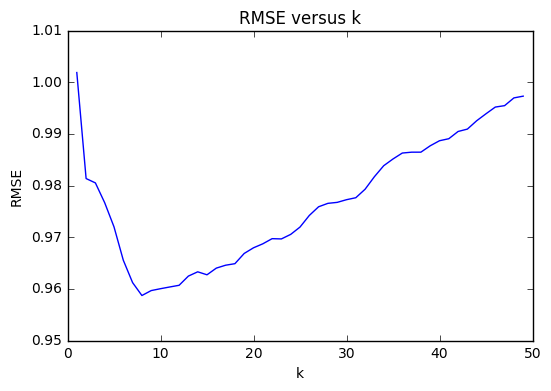

In [20]:
plt.plot(range(1, 50), err)
plt.title('RMSE versus k')
plt.xlabel('k')
plt.ylabel('RMSE')
plt.show()

In [15]:
err.index(min(err))

7

7 is the optimal value of k in this case.  Note that no cross-validation was performed!

Now we'll build the best recommender and recommend 5 movies to each user.

In [17]:
# Build the engine
svd_en = svd_engine(data_movie_raw, k = 7)
svd_en.fit(data_train)
svd_en.predict()

# Now make recommendations
recs = []
for user in data_movie_raw.user_id.unique():
    temp_rec = svd_en.recommend(user, 5)
    recs.append(temp_rec)

In [19]:
recs[0]

Int64Index([197, 9, 318, 357, 64], dtype='int64', name='item_id')